In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.optimizers import Optimizer

np.random.seed(1234)
tf.random.set_seed(1234)

In [10]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )

# PINN: Burger

https://github.com/okada39/pinn_burgers

## Otimizador 

In [2]:
class L_BFGS_B:
    def __init__(self, model, x_train, y_train, factr = 1e7, m=50, maxls=50, maxiter=5000):

        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        # quando iteração termina 
        self.factr = factr
        #The maximum number of variable metric corrections used 
        self.m = m
        #max number of line search steps/iteration
        # nesse caso 50/iteração
        self.maxls = maxls 
        #max number of interation
        self.maxiter = maxiter
    
    # Transforma array 1d de weights em multidimensional array
    # e retorna ao modelo
    def set_weights(self, weights_1d):
        
        weights_shapes = [ w.shape for w in self.model.get_weights() ]
        
        n = [0] + [ np.prod(shape) for shape in weights_shapes ] 
        partition = np.cumsum(n) 

        weights = [ weights_1d[from_part:to_part].reshape(shape)
                        for from_part, to_part, shape 
                        in zip(partition[:-1], partition[1:], weights_shapes) ]
                        
        self.model.set_weights(weights)
    
    @tf.function
    def tf_evaluate(self, x, y):

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_weights)
        return loss, grads

    def evaluate(self, weights_1d):

        self.set_weights(weights_1d)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)

        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def fit(self):

        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])

        fmin_l_bfgs_b(func = self.evaluate, x0 = initial_weights,
                        factr = self.factr, m = self.m,   
                        maxls = self.maxls, maxiter = self.maxiter) 

## Layer: automatic differentiation

In [3]:
class AutomaticDiff(Layer):
    
    def __init__(self, model):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__()

    def call(self, input):
        """
        Computing 1st and 2nd derivatives for Burgers' equation.
        Args:
            x: input variable.
        Returns:
            model output, 1st and 2nd derivatives.
        """
        # Input shape: (batch, input_size)
        # Jacobian outputs shape: (batch, units, input_size)
        with tf.GradientTape() as g:
            g.watch(input)
            with tf.GradientTape() as gg:
                gg.watch(input)
                u = self.model(input) 
            du_dxt =  gg.batch_jacobian(u, input)
            du_dx  = du_dxt[:,:,0]            
            du_dt = du_dxt[:,:,1] 
        d2u_dx2 = g.batch_jacobian(du_dx, input)[:,:,0] 
        return u, du_dt, du_dx, d2u_dx2

## Model: Rede Neural

In [23]:
class NeuralNet(Model):
    
    def __init__(self, units = [32,16,32], input_size = 2, output_size = 1, activation_func = 'tanh', initializer = 'he_normal'):
        super().__init__()
        
        self.units = units
        self.input_size = input_size
        self.output_size = output_size
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden Layer
        self.hidden_layers = []
        count = 0
        for unit in self.units:
            self.hidden_layers.append( Dense( units = unit, 
                                              activation = activation_func, 
                                              kernel_initializer = initializer,
                                              name = 'Hidden/{}'.format(count) ) )
            count += 1
        
        # Output layer
        self.output_layer = Dense( output_size, 
                                   kernel_initializer = initializer, 
                                   name = 'Output' )

    def call(self, x):
        for hidden in self.hidden_layers:
            x = hidden(x)
        x = self.output_layer(x)
        printest("output_layer:",x)
        return x

    def build(self):
        xt =  Input(shape = (self.input_size,), name = 'Input')
        printest("Input:",xt)
        #printest("shape:",self.call(x))
        return Model(inputs = [xt],  
                    outputs = self.call(xt), 
                    name = "NeuralNetwork" )

In [24]:
nn_model = NeuralNet().build()

Input: : 
 KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='Input'), name='Input', description="created by layer 'Input'") 

output_layer: : 
 KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Output/BiasAdd:0', description="created by layer 'Output'") 



## Model: Physics Informed

In [5]:
class PhysicsInformedNN():
    def __init__(self, nu, model ):
        
        """
        Build a PINN model for Burgers' equation.
        Returns:
            PINN model for the projectile motion with
                input: [ (t, x) relative to equation,
                         (t=0, x) relative to initial condition,
                         (t, x=bounds) relative to boundary condition ],
                output: [ u(t,x) relative to equation (must be zero),
                          u(t=0, x) relative to initial condition,
                          u(t, x=bounds) relative to boundary condition ]
        """
        self.model = model
        self.nu = nu
        self.grad = AutomaticDiff(model)
        
    def build(self):
        
        # equation input: (t, x)
        xt = Input(shape=(2,), name = 'InputLayer_xt')
        # initial condition input: (t=0, x)
        xt_0 = Input(shape=(2,), name = 'InputLayer_xt_0')
        # boundary condition input: (t, x=-1) or (t, x=+1)
        xt_bnd = Input(shape=(2,), name = 'InputLayer_xt_bnd')

        # Output---------
        u, du_dt, du_dx, d2u_dx2 = self.grad(xt)

        u = du_dt + u*du_dx - self.nu*d2u_dx2
        u_0 =  self.model(xt_0)
        u_bnd = self.model(xt_bnd)

        return Model(inputs = [xt, xt_0, xt_bnd], 
                     outputs = [u, u_0, u_bnd], 
                     name = 'PhysicsInformedNN')

## Main

In [6]:
n_train = 1000
n_test = 100
nu = 0.01/np.pi 
# Três layers com 32, 16 e 32 neurônios

# Constroi os modelos
nn_model = NeuralNet().build()
pinn_model = PhysicsInformedNN(nu = nu, model = nn_model).build()

# Base de treinamento para o Input -----------------------
# Inicializa pontos aleatórios no dominio (x, t)
x = 2*np.random.rand(n_train , 1) - 1     # x in [-1,1]
t = np.random.rand(n_train , 1)           # t in [0, 1]        
xt = np.concatenate((x,t), axis = 1)
#print("xt.shape = (batch, input_size) : ", xt.shape,)

# Pontos aleatórios para condição inicial: (x_0, t_0 = 0)
x_0 = 2*np.random.rand(n_train , 1) - 1       # x_0 in [-1,1]
t_0 = np.zeros((n_train , 1))                 # t_0 = 0
xt_0 = np.concatenate((x_0, t_0), axis = 1)

# Pontos aleatórios para cond. de contorno (boundary)
t_bnd = np.random.rand(n_train , 1)               # t    [0, 1]
x_bnd = 2*np.round(t_bnd) - 1                           # x   -1 ou 1
xt_bnd = np.concatenate((x_bnd, t_bnd), axis = 1)

# Base de treinamento para o Output ---------------------

# Equação U(x,t) deve ser nula para pontos que satisfaçam a EDP
u = np.zeros((n_train ,1))        # u(x,t) = 0 
# Condição inicial
u_0 = np.sin(-np.pi*x_0)                  # u(0,x)  = -sin(pi x)
# Condição de contorno
u_bnd =  np.zeros((n_train ,1))   # u(t,1) = u(t,-1) = 0 

# Treinando o modelo usando o optimizador L-BFGS-B------------------------
x_train = [xt, xt_0, xt_bnd]            # Dominio (input)  : (1000,2)
y_train = [u, u_0, u_bnd]               # Imagem  (output) : (1000,1)
lbfgs = L_BFGS_B(model = pinn_model, x_train = x_train, y_train = y_train)
lbfgs.fit()

### Model: graph visualization

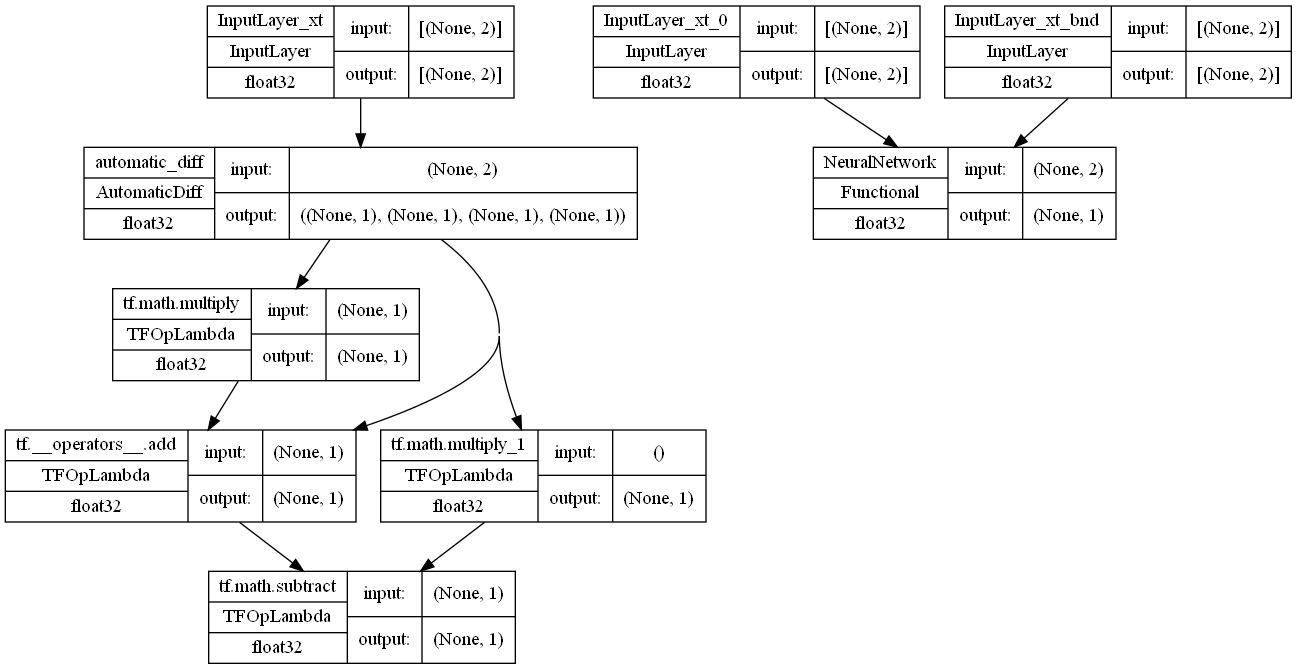

In [7]:
tf.keras.utils.plot_model(pinn_model, to_file= './model_1.png', show_shapes=True, 
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

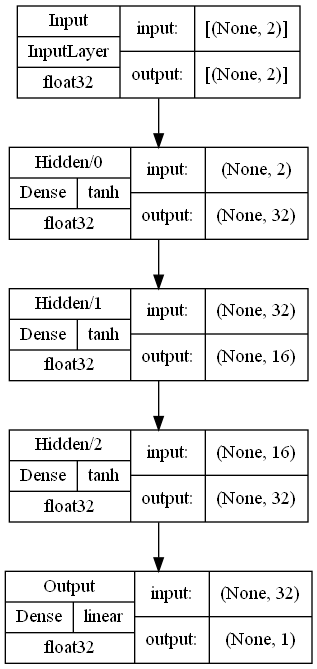

In [8]:
tf.keras.utils.plot_model(nn_model, to_file= './model_1.png', show_shapes=True, 
                    show_dtype=True, show_layer_names=True, show_layer_activations = True)

### Predict and plot

1/1 [==============================] - 0s 12ms/step


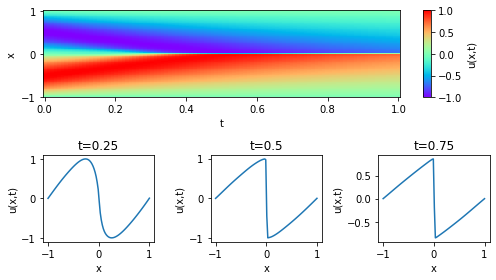

In [9]:
# ====- faz previsões e  plota o grafico =======

# predict u(t,x) distribution
t_flat = np.linspace(0, 1, n_test)
x_flat = np.linspace(-1, 1, n_test)
x,t = np.meshgrid(x_flat, t_flat)
xt = np.stack([x.flatten(), t.flatten()], axis=-1)
u = nn_model.predict(xt, batch_size=n_test)
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(x,t)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.25, 0.5, 0.75]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    xt = np.stack([x_flat, np.full(t_flat.shape, t_cs)], axis=-1)
    u = nn_model.predict(xt, batch_size = n_test)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
plt.tight_layout()
plt.show()